# $\mathcal{N}(y_a,I)+\mathcal{N}(y_b,I)$, $y_a=(0,0), y_b=(10,10)$의 데이터를 학습하는 코드
GAN에 대한 이해는 https://arxiv.org/abs/1701.00160 참조

In [1]:
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams.update({'font.size': 20})

import time
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="3"
torch.set_default_dtype(torch.float64)

### 데이터

In [2]:
device='cuda'
torch.manual_seed(0)

N=1000
y1 = torch.randn([N//2,2],device=device)
y2 = torch.tensor([10,10],device=device)+torch.randn([N//2,2],device=device)
y = torch.concat([y1,y2],0)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


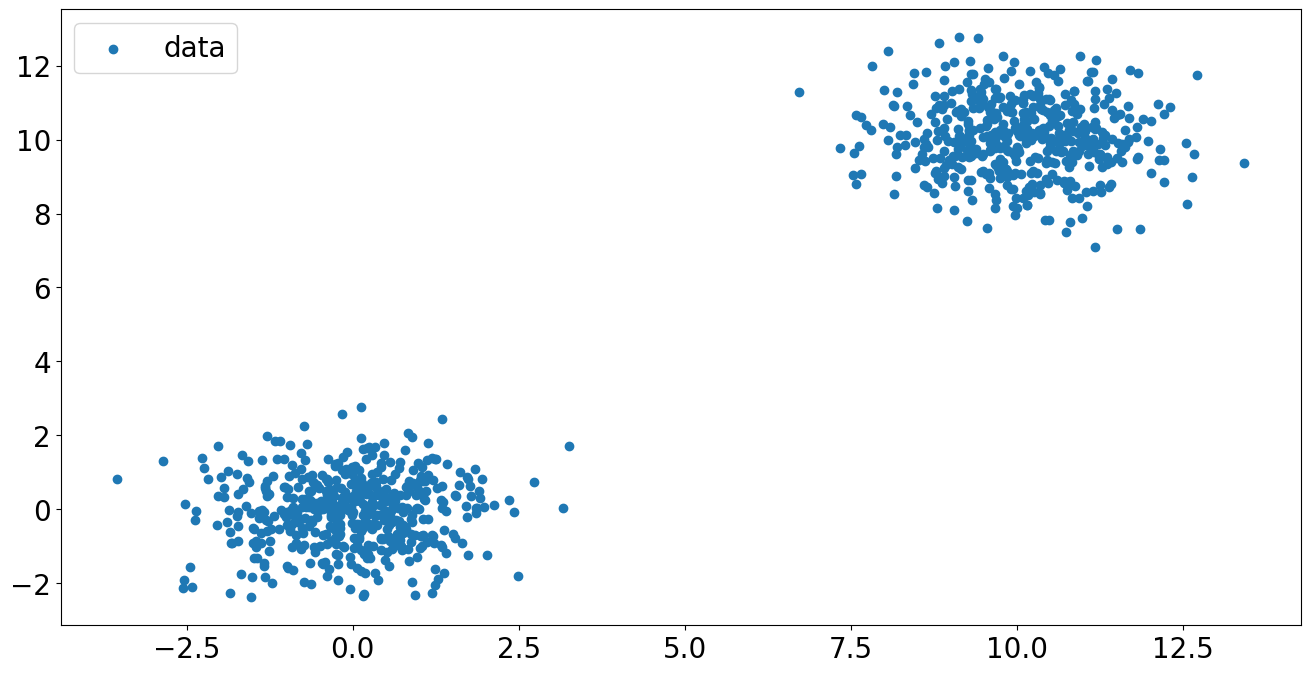

In [3]:
colors = [plt.cm.Paired(i) for i in range(20)]
cmap = {'real':colors[1], 'fake':colors[5], 'ref':'k'}

y_ = y.cpu().detach()
fig = plt.figure(figsize=(16,8))
plt.scatter(y_[:,0],y_[:,1], c=cmap['real'], label='data')
plt.legend()
# plt.title('Mode collapse example')
plt.savefig('images/2DRV_realsamples.png', bbox_inches='tight')

### 모델

In [4]:
class DNN(nn.Module):
    def __init__(self, neurons, activation):

        super(DNN, self).__init__()
        self.activation = activation
        self.n_layers = len(neurons)
        self.dense = {}
        self.nn_layers = nn.ModuleList()

        for i in range(self.n_layers-1):
            self.dense[str(i)] = nn.Linear(neurons[i], neurons[i+1])
            nn.init.xavier_uniform_(self.dense[str(i)].weight)
            nn.init.zeros_(self.dense[str(i)].bias)
            self.nn_layers.append(self.dense[str(i)])
            
    def forward(self, *args):
        x = torch.cat(args,1)
        activation = self.activation
        for i in range(self.n_layers-2):
            x = activation(self.dense[str(i)](x))
        i = self.n_layers-2
        return self.dense[str(i)](x)

In [5]:
net_size_G = [2,32,32,2]
net_size_D = [2,64,64,1]

oG = DNN(net_size_G, activation=torch.tanh).to(device)
oD = DNN(net_size_D, activation=torch.relu).to(device)

G = torch.compile(oG)
D = torch.compile(oD)

### 데이터 학습

In [13]:
def compute_lossD(Z, Y):
    sigma = torch.sigmoid
    Y_gen = G(Z)
    Dreal = sigma(D(Y))
    Dfake = sigma(D(Y_gen))
    lossD = -torch.log(Dreal).mean()-torch.log(1-Dfake).mean()
    return lossD

def compute_lossG(Z):
    sigma = torch.sigmoid
    Y_gen = G(Z)
    Dfake = sigma(D(Y_gen))
    lossG = torch.log(1-Dfake).mean()
    return lossG

def updateD(Z,Y):
    optimizerD.zero_grad()
    lossD = compute_lossD(Z,Y)
    lossD.backward()
    optimizerD.step()

def updateG(Z):
    optimizerG.zero_grad()
    lossG = compute_lossG(Z)
    lossG.backward()
    optimizerG.step()

In [14]:
torch.manual_seed(0)

optimizerD = torch.optim.Adam(D.parameters())
optimizerG = torch.optim.Adam(G.parameters())

st = time.time()
num_epochs = 20000
for epoch in range(num_epochs):
    z = torch.randn([N,2], device=device)
    updateD(z, y)
    updateG(z)
print(f"{time.time()-st} seconds")

63.65711236000061 seconds


### 학습 결과

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


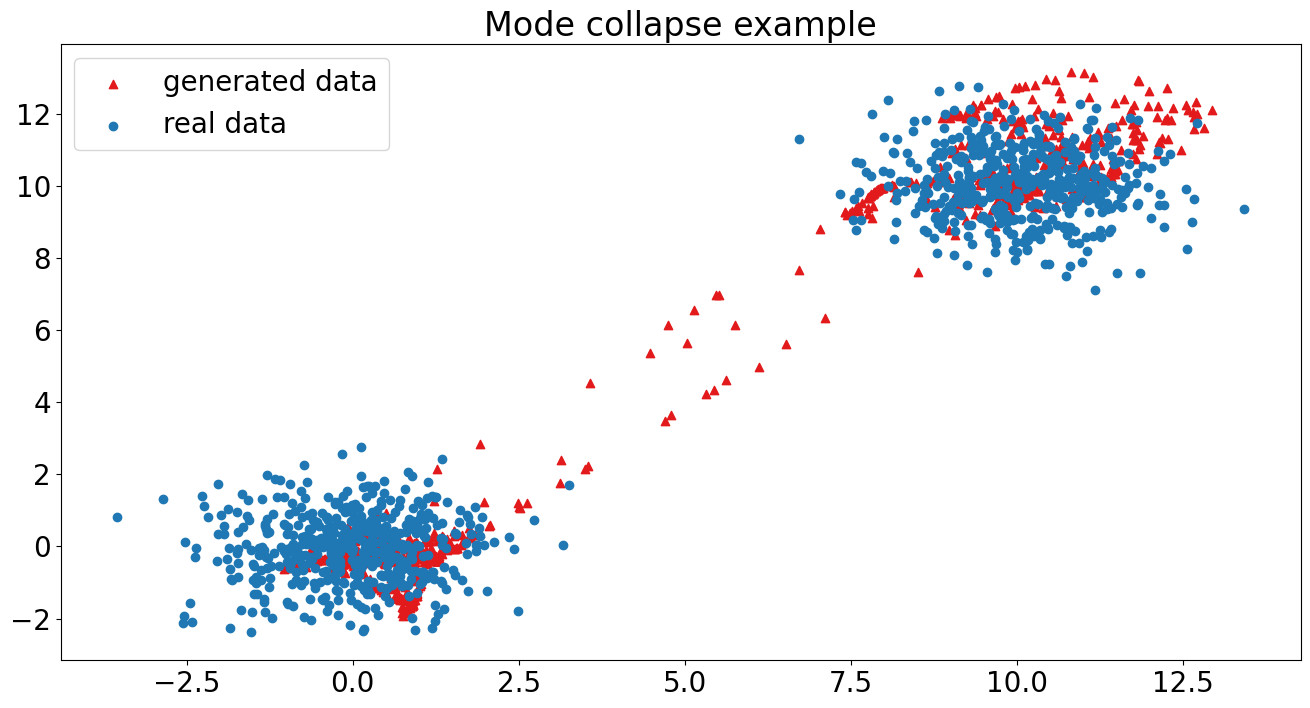

In [15]:
with torch.no_grad():
    z = torch.randn([N,2], device=device)
    y_gen = G(z).cpu()
    
colors = [plt.cm.Paired(i) for i in range(20)]
cmap = {'real':colors[1], 'fake':colors[5], 'ref':'k'}

y_ = y.cpu().detach()
fig = plt.figure(figsize=(16,8))
plt.scatter(y_gen[:,0], y_gen[:,1], marker='^', c=cmap['fake'], label='generated data')
plt.scatter(y_[:,0],y_[:,1], c=cmap['real'], label='real data')
plt.legend()
plt.title('Mode collapse example')
plt.savefig('images/2DRV_samples.pdf', bbox_inches='tight')

# Discriminator만 먼저 1만번 학습하여 overfitting 시키고, 정상적으로 2천번을 학습하면 mode collapse가 일어난다
(GAN tutorial을 보러 왔다면 보지 않아도 됨)

In [ ]:
net_size_G = [2,32,32,2]
net_size_D = [2,64,64,1]

oG = DNN(net_size_G, activation=torch.tanh).to(device)
oD = DNN(net_size_D, activation=torch.relu).to(device)

G = torch.compile(oG)
D = torch.compile(oD)

In [6]:
torch.manual_seed(0)

optimizerD = torch.optim.Adam(D.parameters())
optimizerG = torch.optim.Adam(G.parameters())

num_epochs = 10000
st = time.time()
#warm up
for epoch in range(num_epochs):
    z = torch.randn([N,2], device=device)
    updateD(z, y)
print(f"{time.time()-st} seconds")

st = time.time()
num_epochs = 2000
for epoch in range(num_epochs):
    z = torch.randn([N,2], device=device)
    updateD(z, y)
    updateG(z)
print(f"{time.time()-st} seconds")

24.93362021446228 seconds
7.801713943481445 seconds


Process ForkProcess-22:
Process ForkProcess-17:
Process ForkProcess-14:
Process ForkProcess-15:
Process ForkProcess-7:
Process ForkProcess-1:
Process ForkProcess-2:
Process ForkProcess-5:
Process ForkProcess-4:
Process ForkProcess-12:
Process ForkProcess-24:
Process ForkProcess-8:
Process ForkProcess-26:
Process ForkProcess-3:
Process ForkProcess-18:
Process ForkProcess-20:
Process ForkProcess-21:
Process ForkProcess-28:
Process ForkProcess-16:
Process ForkProcess-6:
Process ForkProcess-29:
Process ForkProcess-19:
Process ForkProcess-9:
Process ForkProcess-13:
Process ForkProcess-30:
Process ForkProcess-32:
Process ForkProcess-25:
Process ForkProcess-27:
Process ForkProcess-23:


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


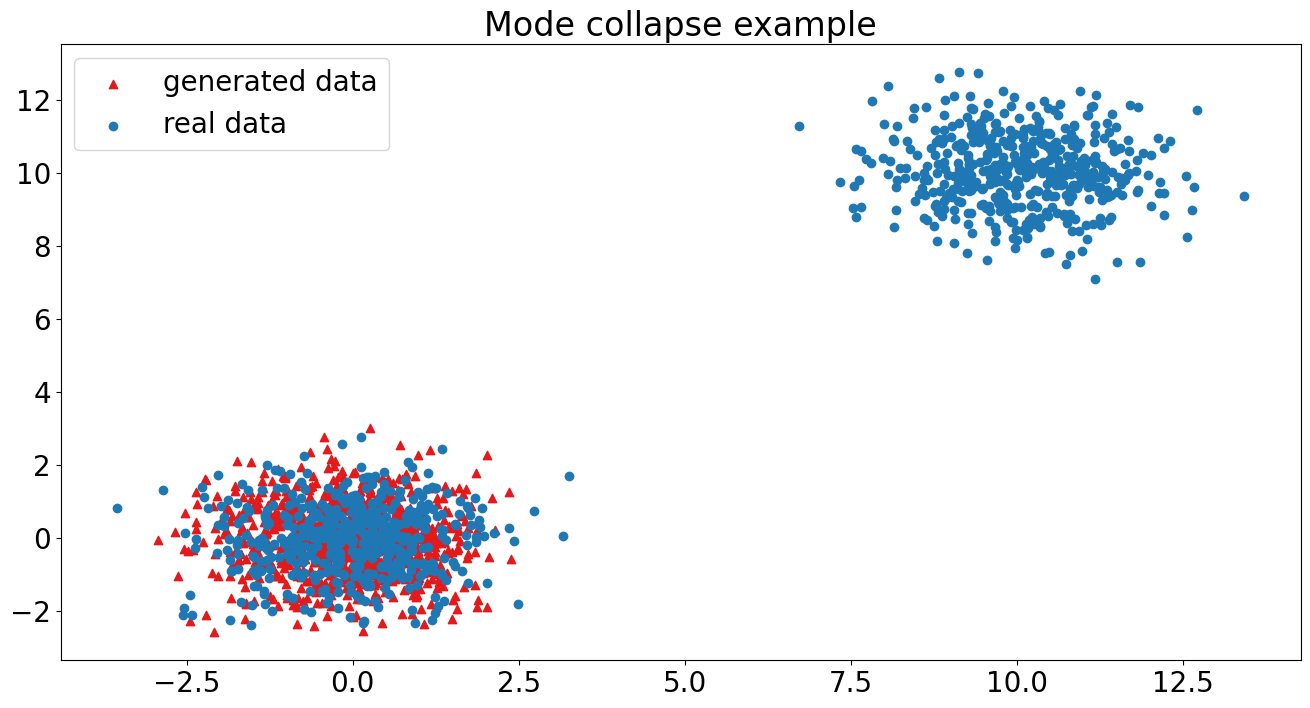

In [10]:
with torch.no_grad():
    z = torch.randn([N,2], device=device)
    y_gen = G(z).cpu()
    
colors = [plt.cm.Paired(i) for i in range(20)]
cmap = {'real':colors[1], 'fake':colors[5], 'ref':'k'}

y_ = y.cpu().detach()
fig = plt.figure(figsize=(16,8))
plt.scatter(y_gen[:,0], y_gen[:,1], marker='^', c=cmap['fake'], label='generated data')
plt.scatter(y_[:,0],y_[:,1], c=cmap['real'], label='real data')
plt.legend()
plt.title('Mode collapse example')
plt.savefig('images/2DRV_samples.pdf', bbox_inches='tight')

In [ ]:
!kill -9 {os.getpid()}